# import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F  # 자주 이용되는 함수 모듈
from torchvision import transforms, datasets

In [2]:
# 사용장비가 cpu인지 gpu인지 확인 (런타임 - 런타임 유형변경에서 확인)
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.10.0+cu111  Device: cuda


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

# 데이터 다운로드 (훈련/검증 데이터)

In [4]:
train_dataset = datasets.MNIST(root = "../data/MNIST",  # 데이터 저장 폴더 지정
                               train = True,            # 학습용 데이터인지를 구분
                               download = True,         # 데이터 다운로드를 수행
                               transform = transforms.ToTensor()) # 이미지 데이터를 전처리하여 (0~1), 텐서로 변경

test_dataset = datasets.MNIST(root = "../data/MNIST",
                              train = False,            # 학습에 사용하지 않는 것을 표시
                              transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE, # 미니 배치 크기로 묶어서 저장한다
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



## 데이터 확인하기

In [5]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


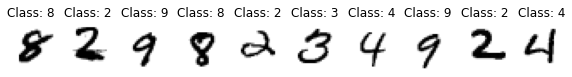

In [8]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

# MLP 모델 구성

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # 1차원 어레이, 즉 벡터로 변환한다
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [10]:
# 모델 환경 설정, 디바이스 설정

model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [11]:
# MLP 모델 학습 및 성능 확인 함수 정의
def train(model, train_loader, optimizer, log_interval):
    model.train() # 모델을 학습 상태로 지정
    for batch_idx, (image, label) in enumerate(train_loader): # 미니 배치 단위로 처리
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image) # 미니 배치 단위로 그라디언트 초기화
        loss = criterion(output, label) # 손실 함수 계산
        loss.backward() # 역전파
        optimizer.step() # 학습 (업데이트)

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [12]:
# 검증 데이터에 대한 모델 성능확인 함수 정의
def evaluate(model, test_loader):
    model.eval() # 학습이 완료된 모델을 평가 상태로 지정
    test_loss = 0
    correct = 0

    with torch.no_grad(): # 그라디언트의 흐름을 막는다
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item() # 크로스 엔트로피 계산
            prediction = output.max(1, keepdim = True)[1] # 확률이 최대치인 위치 찾기
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset) # 정확도 계산
    return test_loss, test_accuracy

In [13]:
# 훈련 및 검증
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.381005
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 2.276627
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 2.329586
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 2.302453
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 2.280228
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 2.267875
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 2.320781
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 2.276777
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 2.239449
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 2.289326

[EPOCH: 1], 	Test Loss: 2.2365, 	Test Accuracy: 37.74 % 

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 2.239278
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 2.185907
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 2.190157
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 2.082212
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 1.931332
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 1.889003
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 1.740019
T